In [51]:
# Practical 3

%matplotlib inline

import torch
from torch import Tensor
import dlc_practical_prologue as prologue
from matplotlib import pyplot as plt
import time

In [2]:
def sigma(x):
    return torch.tanh(x)

def dsigma(x):
    return 1 - torch.pow(torch.tanh(x),2)

In [3]:
def loss(v,t):
    return torch.sum(torch.pow(t-v,2))

def dloss(v,t):
    return -2*(t-v)

In [31]:
def forward_pass(w1, b1, w2, b2, x):
    s1 = w1.mm(x) + b1
    x1 = sigma(s1)
    s2 = w2.mm(x1) + b2
    x2 = sigma(s2)
    return x,s1,x1,s2,x2

def backward_pass(w1, b1, w2, b2,
                  t,
                  x, s1, x1, s2, x2,
                  dl_dw1, dl_db1, dl_dw2, dl_db2):
    
    dl_dx2 = dloss(x2,t)
    dl_ds2 = dl_dx2 * dsigma(s2)
    dl_dx1 = w2.t().mm(dl_ds2)
    dl_ds1 = dl_dx1 * dsigma(s1)
    
    dl_dw2 += dl_ds2.mm(x1.view(1,-1))
    dl_dw1 += dl_ds1.mm(x.view(1,-1))
    dl_db2 += dl_ds2
    dl_db1 += dl_ds1
    
    

In [8]:
# Load MNIST dataset (reduced set)
train_input, train_target, test_input, test_target = prologue.load_data(
    cifar = None, one_hot_labels = True, normalize = True, flatten = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


Started learning:
| 0 /1000 done, time remaining: 296 seconds
| 100 /1000 done, time remaining: 253 seconds
| 200 /1000 done, time remaining: 212 seconds
| 300 /1000 done, time remaining: 197 seconds
| 400 /1000 done, time remaining: 150 seconds
| 500 /1000 done, time remaining: 125 seconds
| 600 /1000 done, time remaining: 94 seconds
| 700 /1000 done, time remaining: 84 seconds
| 800 /1000 done, time remaining: 59 seconds
| 900 /1000 done, time remaining: 27 seconds


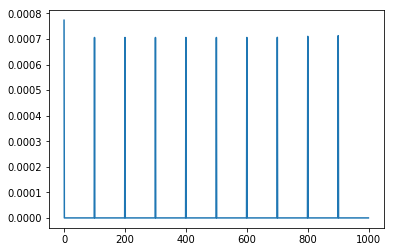

In [84]:
# Create and train the network

# Make sure the data is contained within [0,1[
test_target *= 0.9
train_target *= 0.9

# Number of samples
num = train_input.size()[0]
# Dimension of a single sample
dim = train_input.size()[1]

# Parameters of the network
w1 = torch.empty((50,dim)).normal_(0,1e-6)
w2 = torch.empty((10,50)).normal_(0,1e-6)
b1 = torch.empty((50,1)).normal_(0,1e-6)
b2 = torch.empty((10,1)).normal_(0,1e-6)

# Update parameters
dl_dw1 = torch.empty((50,dim)).zero_()
dl_dw2 = torch.empty((10,50)).zero_()
dl_db1 = torch.zeros((50,1))
dl_db2 = torch.zeros((10,1))

eta = 0.1
_loss = [0]*1000
# make 1000 runs through the dataset
print('Started learning:')
for p in range(0,1000):
    # Learn from each sample
    start = time.time()
    for i in range(0,num):
        # Get a sample
        x = train_input[i,:].view(-1,1)
        t = train_target[i,:].view(-1,1)
        # Make a forward and backward pass
        _,s1,x1,s2,x2 = forward_pass(w1, b1, w2, b2, x)
        backward_pass(w1, b1, w2, b2,
                      t,
                      x, s1, x1, s2, x2,
                      dl_dw1, dl_db1, dl_dw2, dl_db2)
    end = time.time()
    time_left = (end-start)*(1000-p)
    
    # Display progress and remaining time
    if p%100 is 0:
        print('|',p,'/1000 done, time remaining: %.0f seconds'%time_left)
        _loss[p] = loss(t,x2)
    
    # Update the weights after one run through the dataset
    w1 -= eta*dl_dw1/num
    w2 -= eta*dl_dw2/num
    b1 -= eta*dl_db1/num
    b2 -= eta*dl_db2/num
    
    # Reinitialize the derivatives
    dl_dw1.zero_()
    dl_dw2.zero_()
    dl_db1.zero_()
    dl_db2.zero_()
    
plt.plot(_loss)
plt.show()

In [85]:
# Evaluate the network on the training set
correct = 0
for i in range(train_input.size()[0]):
    x = train_input[i,:].view(-1,1)
    t = train_target[i,:].view(-1,1)
    _,s1,x1,s2,x2 = forward_pass(w1, b1, w2, b2, x)
    
    _,label = x2.max(0)
    _,tlabel= t.max(0)
    if label == tlabel:
        correct += 1
    
print('Error rate on the training set: ',(train_input.size()[0]-correct)/train_input.size()[0]*100,'%')


# Evaluate the network on the testing set
correct = 0
for i in range(test_input.size()[0]):
    x = test_input[i,:].view(-1,1)
    t = test_target[i,:].view(-1,1)
    _,s1,x1,s2,x2 = forward_pass(w1, b1, w2, b2, x)
    
    _,label = x2.max(0)
    _,tlabel= t.max(0)
    if label == tlabel:
        correct += 1
    
print('Error rate on the testing set: ',(test_input.size()[0]-correct)/test_input.size()[0]*100,'%')

Error rate on the training set:  64.9 %
Error rate on the testing set:  67.9 %


In [73]:
a = torch.tensor([1,2,3,4,3]).view(-1,1)
print(a.max(0))
print(a)

(tensor([4]), tensor([3]))
tensor([[1],
        [2],
        [3],
        [4],
        [3]])
